In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import colors
import matplotlib
import matplotlib.ticker as mtick
from tqdm.notebook import tqdm
import pingouin as pg
from adjustText import adjust_text
from scipy.spatial import ConvexHull, Delaunay
# from shapely.geometry import Point, Polygon
from pybaseball import playerid_reverse_lookup

%matplotlib inline 

In [2]:
%cd C:/Users/citioplab/works/codes/baseball_projects/

C:\Users\citioplab\works\codes\baseball_projects


In [3]:
seed = 1126

### Data Preprocessing

In [4]:
## Define Strikezone
strike_zone = pd.DataFrame({
  'PlateLocSide': [-0.708, -0.708, 0.708, 0.708, -0.708],
  'PlateLocHeight': [1.5, 3.5, 3.5, 1.5, 1.5]
})

## Add strike zone to Plot
def draw_line(axis, alpha_spot = 1, catcher_p = True):
    axis.plot(strike_zone['PlateLocSide'], strike_zone['PlateLocHeight'], color = 'black', linewidth = 1.3, zorder = 3, alpha = alpha_spot,)

In [5]:
colour_palette = ['#FFB000','#648FFF','#785EF0',
                  '#DC267F','#FE6100','#3D1EB2','#894D80','#16AA02','#B5592B','#A3C1ED']

In [6]:
data_2021 = pd.read_csv('./data/2021_data.csv')
data_2022 = pd.read_csv('./data/2022_data.csv')
data_2023 = pd.read_csv('./data/2023_data.csv')
data_2024 = pd.read_csv('./data/2024_data.csv')

In [7]:
## Define a dictionary to group outcomes together
des_dict = {'ball':'ball',
'hit_into_play':'hit_into_play',
'called_strike':'called_strike',
'foul':'foul',
'swinging_strike':'swinging_strike',
'blocked_ball':'ball',
'swinging_strike_blocked':'swinging_strike',
'foul_tip':'swinging_strike',
'foul_bunt':'foul',
'hit_by_pitch':'hit_by_pitch',
'pitchout':'ball',
'missed_bunt':'swinging_strike',
'bunt_foul_tip':'swinging_strike',
'foul_pitchout':'foul',}

## Define a dictionary to group events together
ev_dict = {
 'single':'single',
 'walk':'walk',
 np.nan:np.nan,
 'strikeout':'strikeout',
 'field_out':'field_out',
 'force_out':'field_out',
 'double':'double',
 'hit_by_pitch':'hit_by_pitch',
 'home_run':'home_run',
 'grounded_into_double_play':'field_out',
 'fielders_choice_out':'field_out',
 'fielders_choice':'field_out',
 'field_error':'field_out',
 'double_play':'field_out',
 'sac_fly':'field_out',
 'strikeout_double_play':np.nan,
 'triple':'triple',
 'sac_bunt':'field_out',
 'catcher_interf':np.nan,
 'sac_fly_double_play':'field_out',
 'triple_play':'field_out',
 'other_out':'field_out',
 'wild_pitch':'wild_pitch',
 'sac_bunt_double_play':'field_out',
 'truncated_pa': np.nan}

In [8]:
swing_in = ['foul_bunt','foul','hit_into_play','swinging_strike', 'foul_tip', 'swinging_strike_blocked','missed_bunt','bunt_foul_tip', 'foul_pitchout']

In [9]:
## Define a function which applies relevant transformations
def df_clean(df):
    # Create a new column with the grouped decisions
    df['des_new'] = df.description.map(des_dict)
    # Create a new column with the grouped events
    df['ev_new'] = df.loc[df['des_new'] == 'hit_into_play', 'events'].map(ev_dict)
    df.loc[df['des_new'] == 'hit_into_play', 'des_new'] = df.loc[df['des_new'] == 'hit_into_play', 'ev_new']
    df = df.dropna(subset = ['des_new'])
    # Filter rare cases
    df = df[(df.strikes <= 2) & (df.balls <= 3)]
    df.loc[:, 'count'] = df.loc[:, 'balls'].astype(str) + '-' + df.loc[:, 'strikes'].astype(str)
    df['count'] = df['count'].astype("category")
    # Create a dataset with average run expectancy 
    # given outcome and count
    des_values = df.groupby(['des_new', 'count'], observed = False)['delta_run_exp'].mean()
    # Merge the average run expectancies to the dataset
    df = df.merge(des_values, left_on = ['des_new', 'count'], right_on = ['des_new', 'count'], suffixes = ['', '_mean'])
    # Add a binary columns for swings
    conditions_swings = [(df['description'].isin(swing_in))]
    choices_swings = [True]
    df['swing'] = np.select(conditions_swings, choices_swings, default = 0)
    
    return df

## Transform the Datasets
processed_data_2021 = df_clean(df = data_2021).dropna(subset = ['pitch_type'])
processed_data_2022 = df_clean(df = data_2022).dropna(subset = ['pitch_type'])
processed_data_2023 = df_clean(df = data_2023).dropna(subset = ['pitch_type'])
processed_test_data = df_clean(df = data_2024).dropna(subset = ['pitch_type'])

In [9]:
def get_convex_hull(df):
    df = df.dropna(subset = 'launch_speed').reset_index(drop = True)

    if df.shape[0] < 60:
        return None # Convex hull not defined for < 3 points

    threshold = np.percentile(df['launch_speed'].values, 95)
    points = np.stack((df.loc[df['launch_speed'] >= threshold, 'plate_x'].values, df.loc[df['launch_speed'] >= threshold, 'plate_z'].values), axis = 1)
    
    hull = ConvexHull(points)
    return hull

In [10]:
def is_inside_hull(row):
    plate_x, plate_z, hull = row
    point = np.array([plate_x, plate_z])
    result = np.all(np.dot(hull.equations[:, :-1], point) + hull.equations[:, -1] <= 0)

    return result

In [11]:
def add_nitro_zone(df):
    nitro_zone = df.loc[df['description'] == 'hit_into_play', :].groupby('batter')[['launch_speed', 'plate_x', 'plate_z']].apply(get_convex_hull)
    nitro_zone = nitro_zone.dropna().reset_index()
    nitro_zone.columns = ['batter', 'nitro_zone']
    df = df.merge(nitro_zone, on = 'batter')

    return df

In [72]:
processed_data_2021 = add_nitro_zone(processed_data_2021)
processed_data_2022 = add_nitro_zone(processed_data_2022)
processed_data_2023 = add_nitro_zone(processed_data_2023)
processed_test_data = add_nitro_zone(processed_test_data)

In [73]:
processed_data_2021.loc[:, 'in_nitro'] = processed_data_2021.loc[:, ['plate_x', 'plate_z', 'nitro_zone']].apply(is_inside_hull, axis = 1)
processed_data_2022.loc[:, 'in_nitro'] = processed_data_2022.loc[:, ['plate_x', 'plate_z', 'nitro_zone']].apply(is_inside_hull, axis = 1)
processed_data_2023.loc[:, 'in_nitro'] = processed_data_2023.loc[:, ['plate_x', 'plate_z', 'nitro_zone']].apply(is_inside_hull, axis = 1)
processed_test_data.loc[:, 'in_nitro'] = processed_test_data.loc[:, ['plate_x', 'plate_z', 'nitro_zone']].apply(is_inside_hull, axis = 1)

In [74]:
processed_train_data = pd.concat([processed_data_2021, processed_data_2022, processed_data_2023]).reset_index(drop = True)

In [75]:
print(processed_train_data.shape)
print(processed_test_data.shape) 

(2027439, 125)
(678107, 125)


### EDA

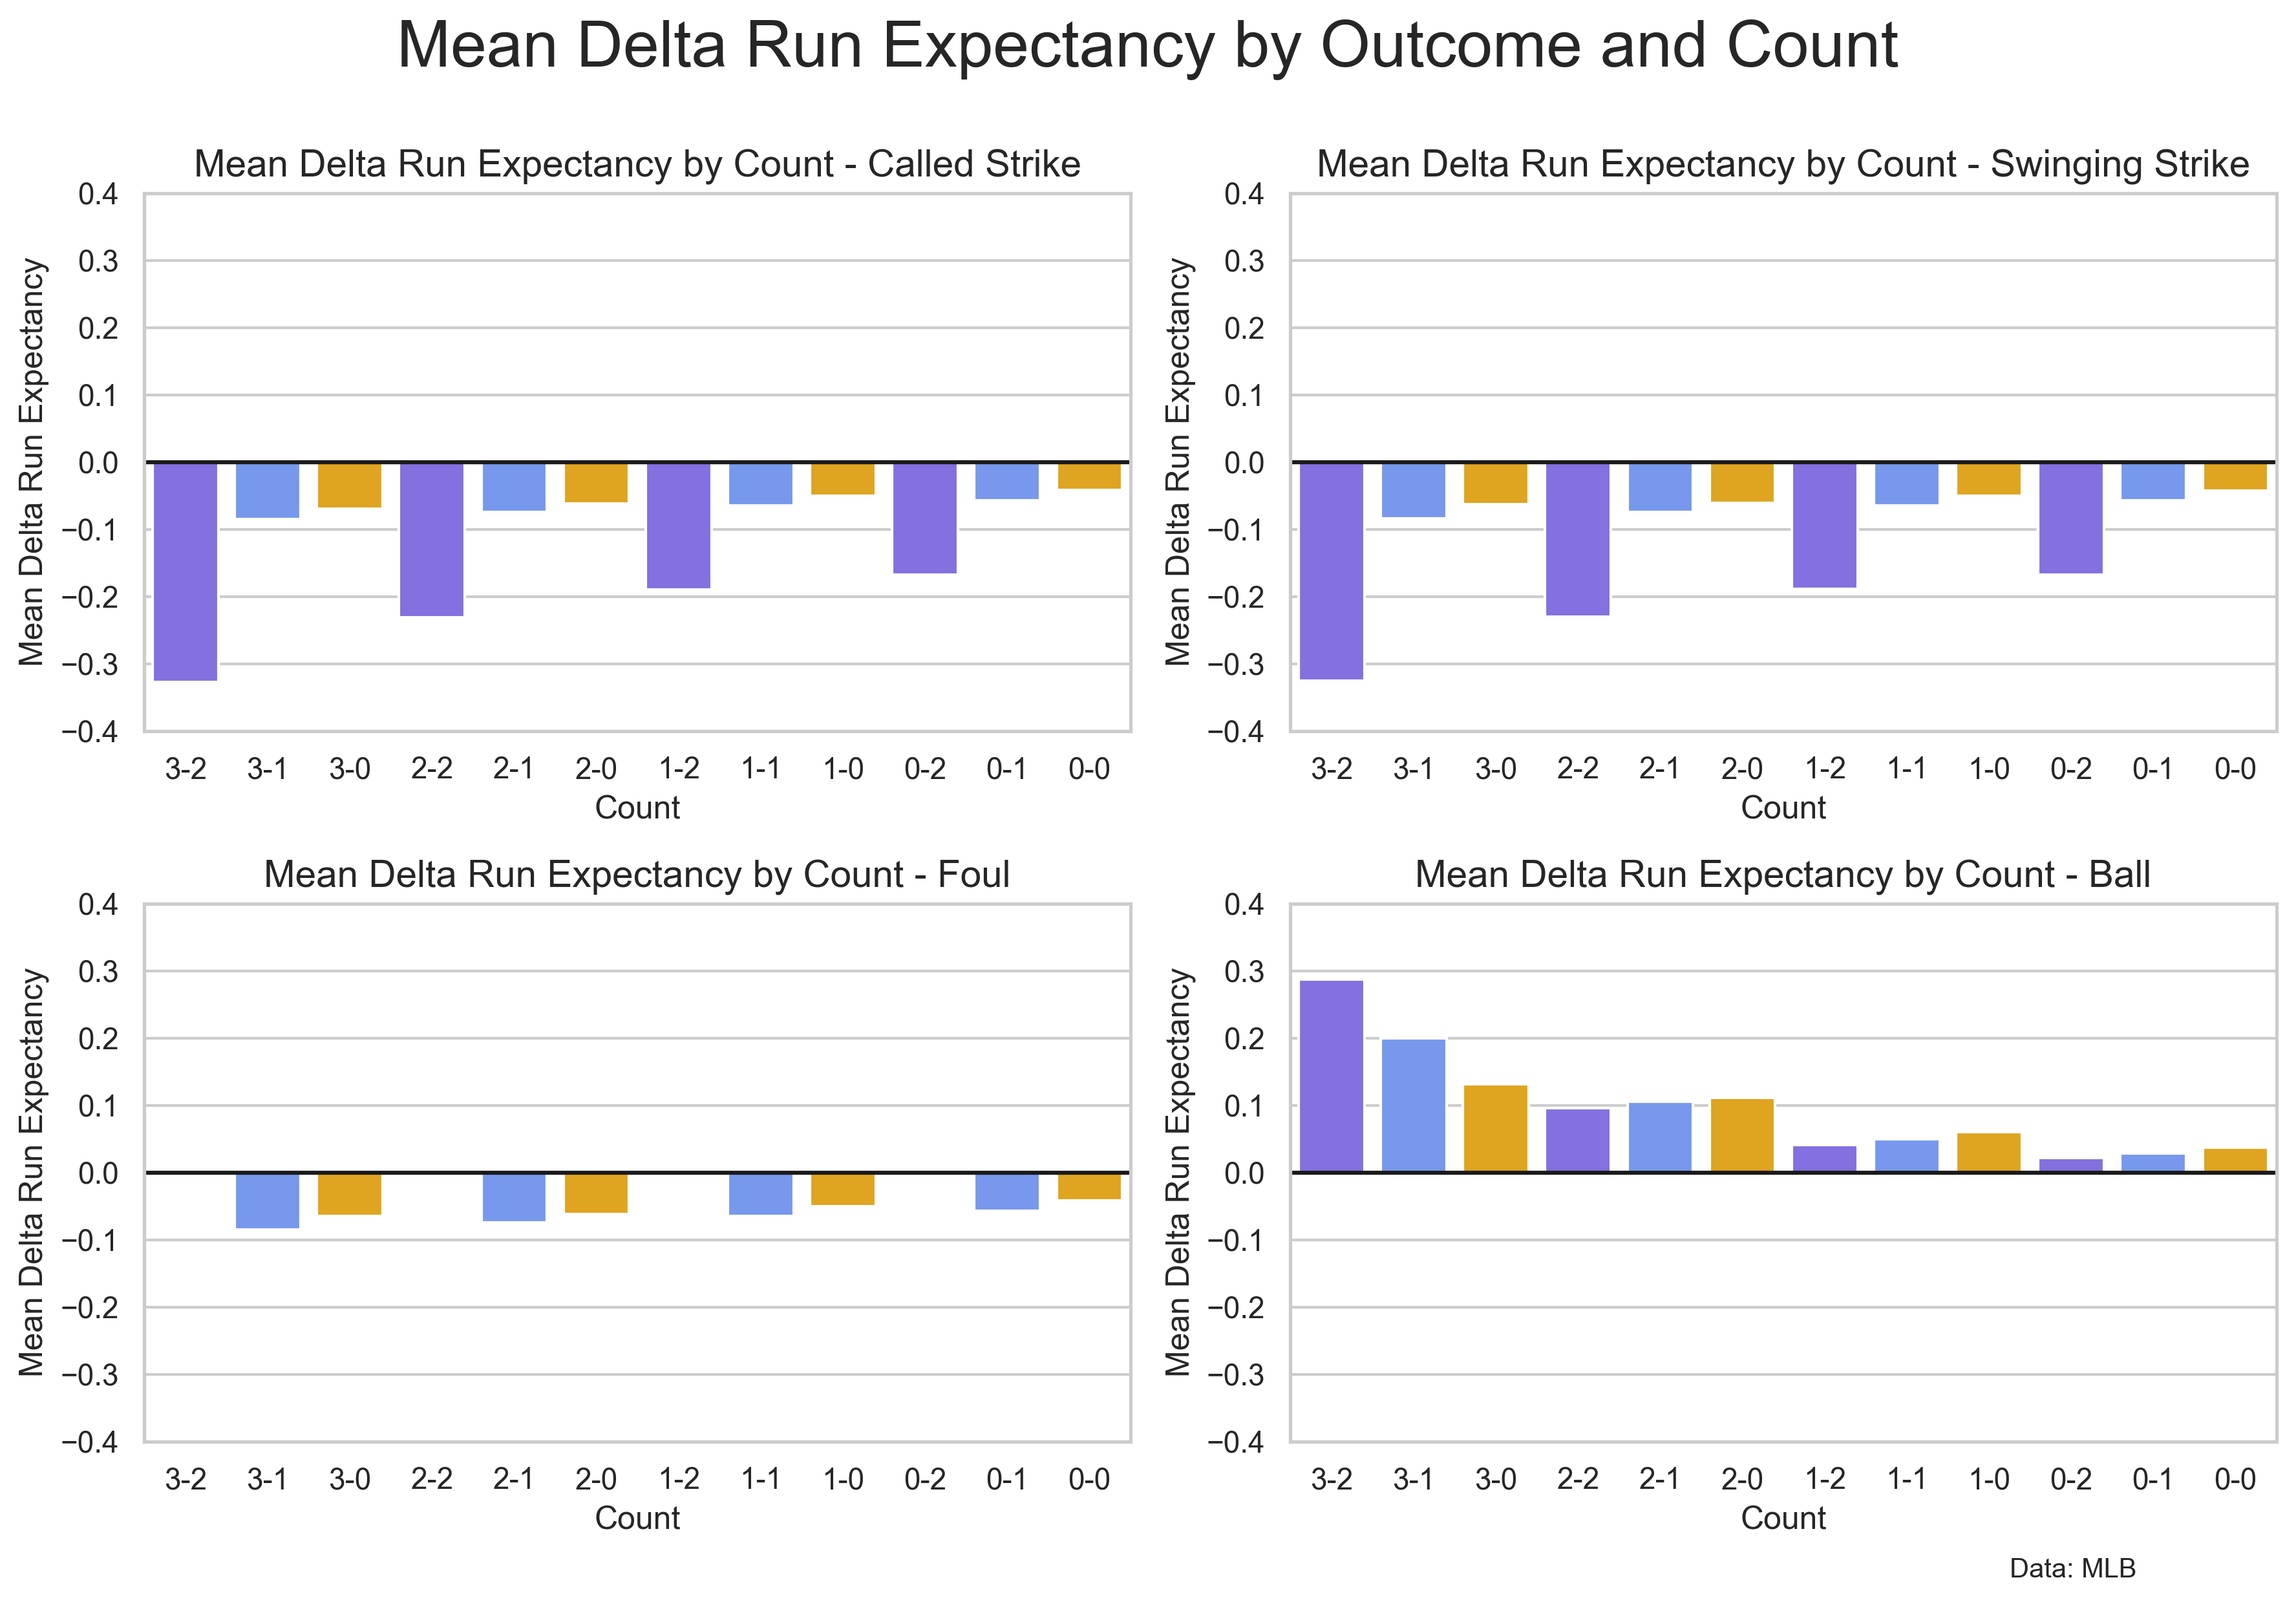

In [18]:
## Create Dataframe to plot Run Expectancies for Hits into Play
outcomes_delta = ['swinging_strike', 'called_strike', 'foul', 'ball']
outcomes_df = processed_train_data.groupby(['des_new', 'strikes', 'balls'])['delta_run_exp_mean'].mean().sort_values().reset_index()
outcomes_df = outcomes_df[outcomes_df.des_new.isin(outcomes_delta)]
outcomes_df = outcomes_df[(outcomes_df.strikes <= 2) & (outcomes_df.balls <= 3)]
outcomes_df['count'] = outcomes_df.balls.astype(str) + '-' + outcomes_df.strikes.astype(str)
outcomes_df = outcomes_df.sort_values(['balls', 'strikes'], ascending = False)
 

outcome_titles = {'swinging_strike':'Swinging Strike',
'called_strike':'Called Strike',
'foul':'Foul',
'hit_into_play':'Hit Into Play',
'ball':'Ball'}


sns.set_theme(style = "whitegrid")

fig, ax = plt.subplots(2, 2, figsize = (12, 8), dpi = 300)

axs = ax.flatten()
for outx in range(0, outcomes_df.des_new.nunique()):
    
    sns.barplot(data = outcomes_df[outcomes_df.des_new == outcomes_df.des_new.unique()[outx]],
                y = 'delta_run_exp_mean', x = 'count', hue = 'count', palette = colour_palette[2::-1] * 4, ax = axs[outx])

    axs[outx].set_ylim(-0.4, 0.4)
    axs[outx].hlines(y = 0, xmin = -0.5, xmax = 11.5, color = 'k')
    axs[outx].set_xlim(-0.5, 11.5)

    axs[outx].set_xlabel('Count')
    axs[outx].set_ylabel('Mean Delta Run Expectancy')
    axs[outx].set_title(f'Mean Delta Run Expectancy by Count - {outcome_titles[outcomes_df.des_new.unique()[outx]]}', fontsize = 14)

fig.suptitle(x = 0.5, y = 0.98, t = "Mean Delta Run Expectancy by Outcome and Count", ha = 'center', va = 'center', fontsize = 24)
fig.text(0.925, 0.00, "Data: MLB", ha = 'right', va = 'center', fontsize = 10)
fig.set_facecolor('white')
fig.tight_layout()

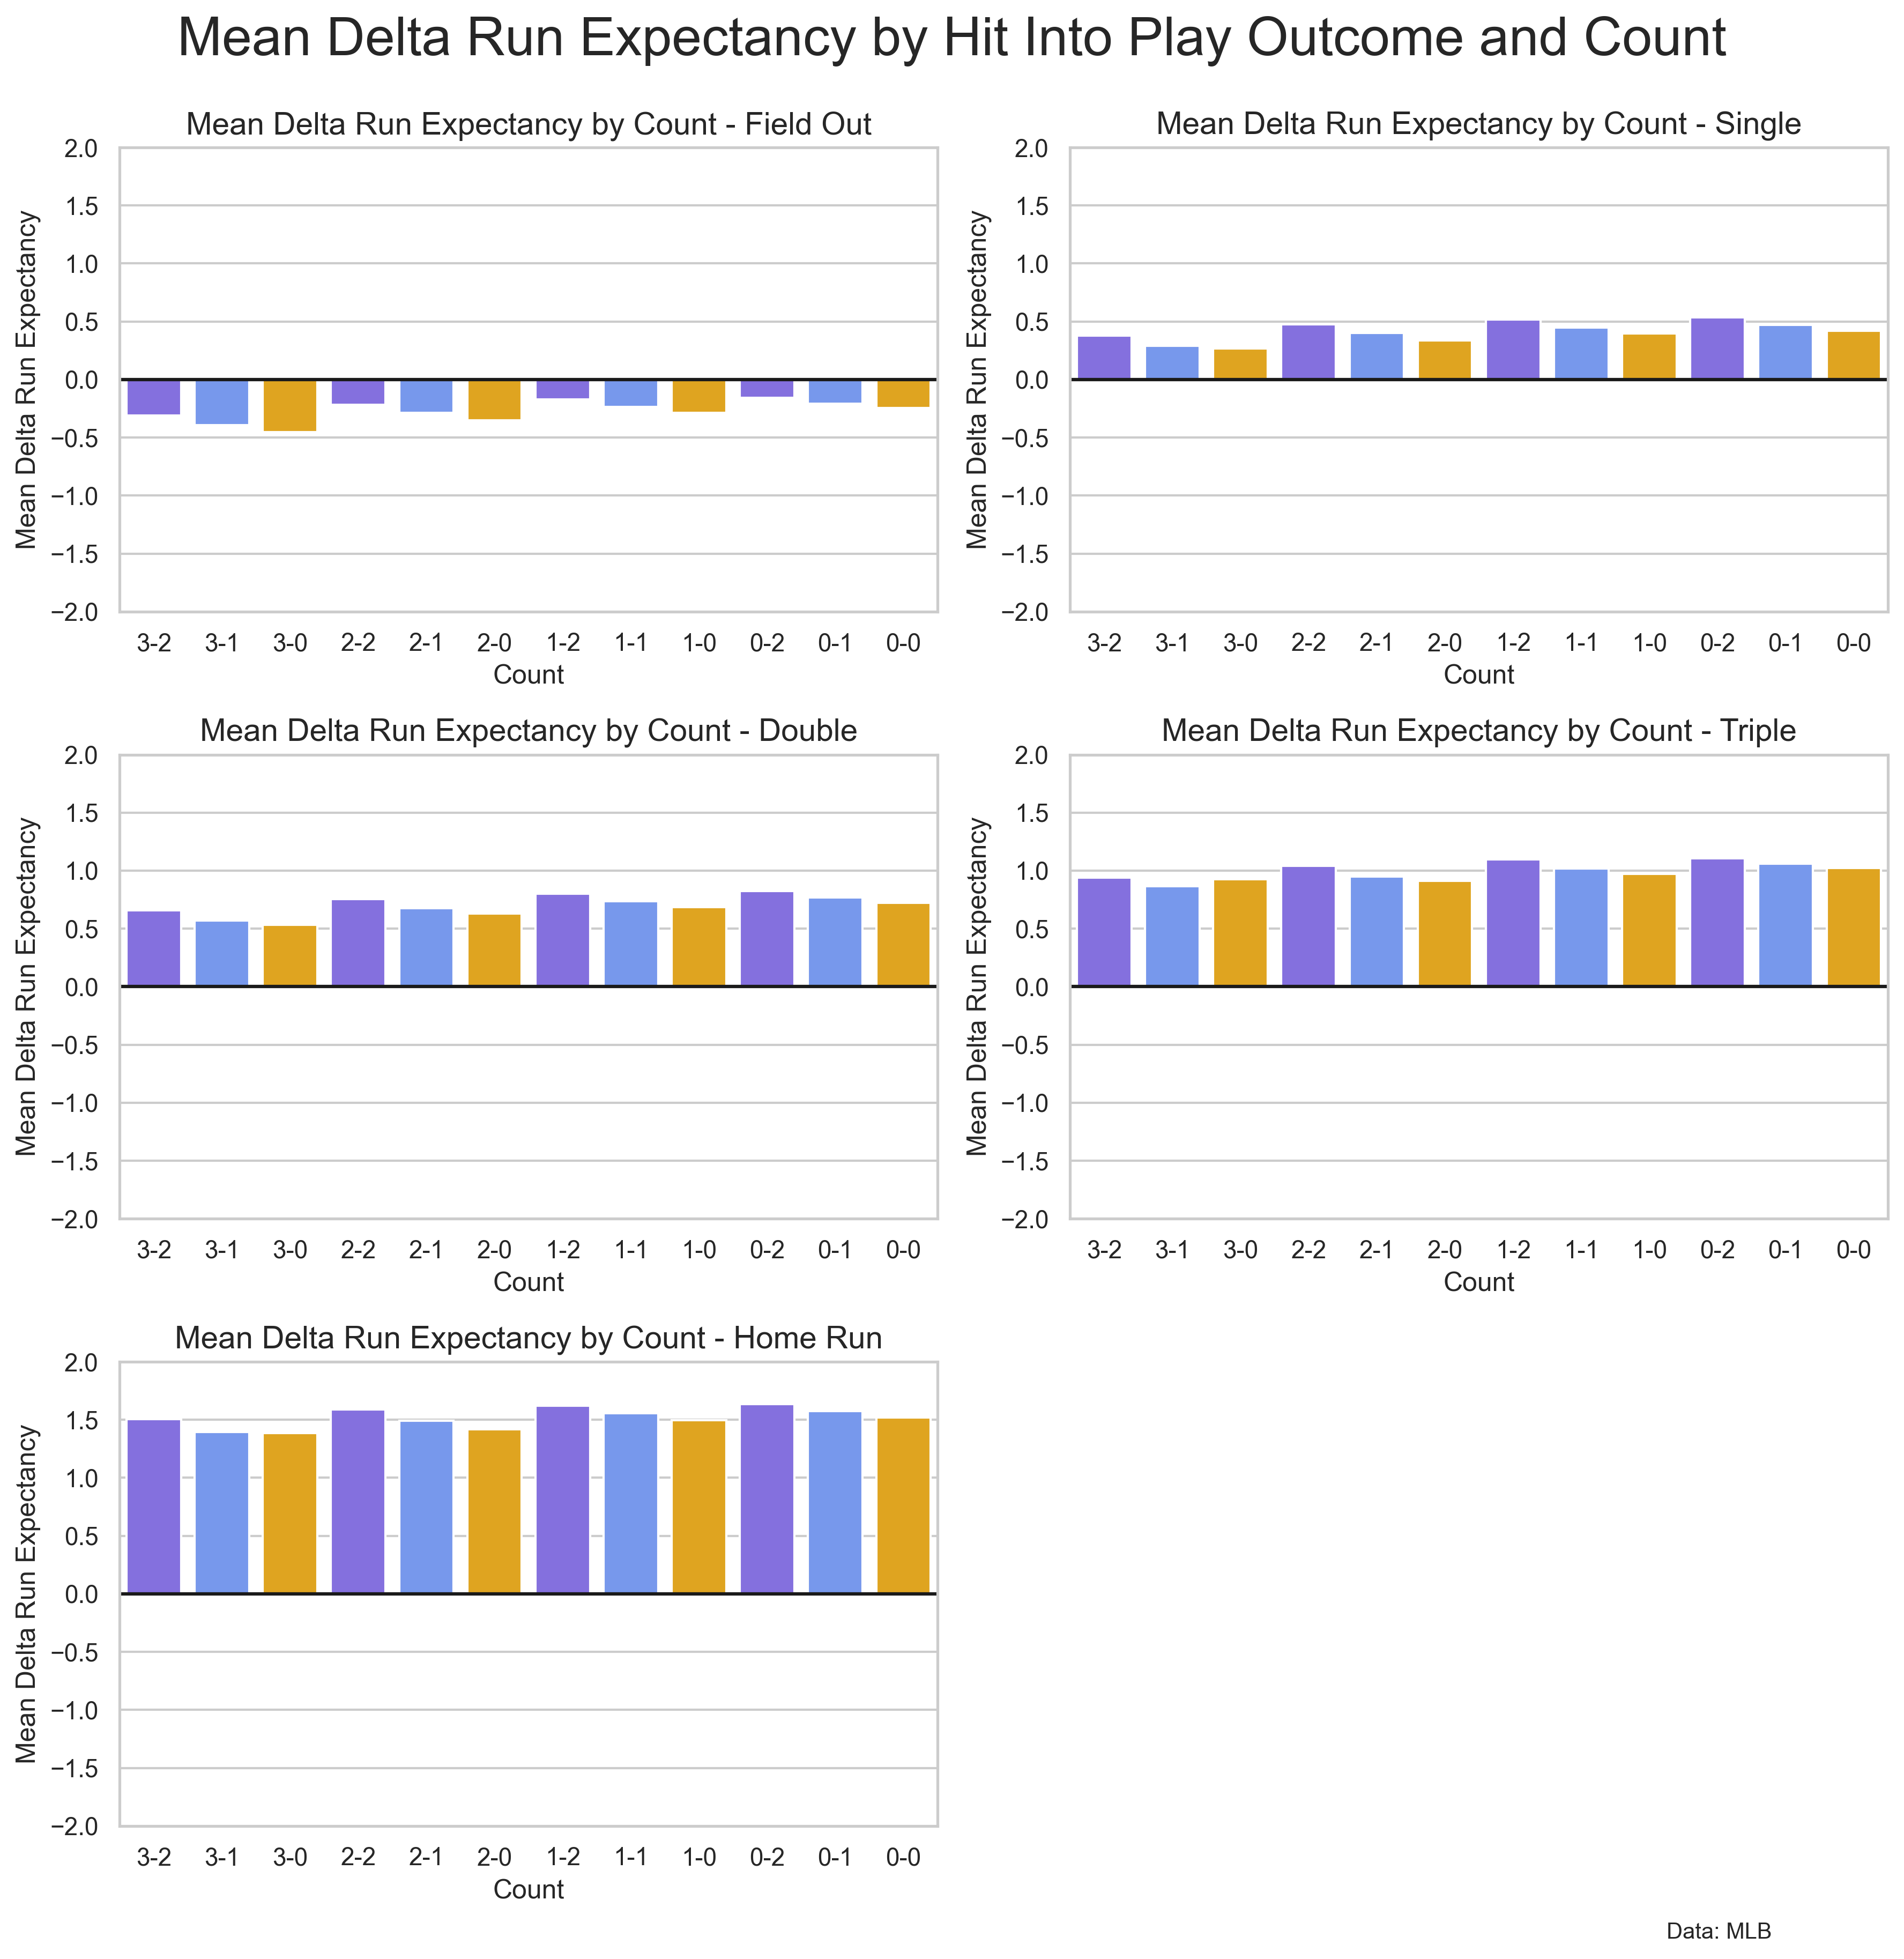

In [19]:
## Create Dataframe to plot Run Expectancies for Hits into Play
outcomes_df_hit = processed_train_data[processed_train_data.description == 'hit_into_play'].groupby(['ev_new', 'strikes', 'balls'])['delta_run_exp_mean'].mean().sort_values().reset_index()
outcomes_df_hit = outcomes_df_hit[outcomes_df_hit.ev_new.isin(processed_train_data[processed_train_data.description == 'hit_into_play'].ev_new.unique())]
outcomes_df_hit = outcomes_df_hit[(outcomes_df_hit.strikes <= 2) & (outcomes_df_hit.balls <= 3)]
outcomes_df_hit['count'] = outcomes_df_hit.balls.astype(str) + '-' + outcomes_df_hit.strikes.astype(str)
outcomes_df_hit = outcomes_df_hit.sort_values(['balls', 'strikes'], ascending = False)


outcome_titles_hit = {'single':'Single',
'field_out':'Field Out',
'double':'Double',
'home_run':'Home Run',
'triple':'Triple'}


sns.set_theme(style = "whitegrid")

fig, ax = plt.subplots(3, 2, figsize = (12, 12), dpi = 300)

axs = ax.flatten()
axs[5].axis('off')
for outx in range(0, len(outcomes_df_hit.ev_new.unique())):
    
    sns.barplot(data = outcomes_df_hit[outcomes_df_hit.ev_new == outcomes_df_hit.ev_new.unique()[outx]],
                y = 'delta_run_exp_mean', x = 'count', hue = 'count', palette = colour_palette[2::-1] * 4, ax = axs[outx])

    axs[outx].set_ylim(-2, 2)
    axs[outx].hlines(y = 0, xmin = -0.5, xmax = 11.5, color = 'k')
    axs[outx].set_xlim(-0.5, 11.5)

    axs[outx].set_xlabel('Count')
    axs[outx].set_ylabel('Mean Delta Run Expectancy')
    axs[outx].set_title(f'Mean Delta Run Expectancy by Count - {outcome_titles_hit[outcomes_df_hit.ev_new.unique()[outx]]}', fontsize = 14)

fig.suptitle(x = 0.5, y = 0.98, t = "Mean Delta Run Expectancy by Hit Into Play Outcome and Count", ha = 'center', va = 'center', fontsize = 24)
fig.text(0.925, 0.00, "Data: MLB", ha = 'right', va = 'center', fontsize = 10)
fig.set_facecolor('white')
fig.tight_layout()

In [1]:
x_min = -2.5
x_max = 2.5
y_min = 0
y_max = 5
extent = [x_min, x_max, y_min, y_max]

# define your scale, with white at zero
vmin = -0.1
vmax = 0.1

#for p_th in range(0,2):
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(1, 2, figsize = (16, 8), dpi = 300)
norm = colors.TwoSlopeNorm(vmin = vmin, vcenter = np.array([vmin,vmax]).mean(), vmax = vmax)
#norm = plt.Normalize(vmin,vmax)
sm = plt.cm.ScalarMappable(cmap = 'RdBu_r', norm = norm)


ax[0].hexbin(x = processed_train_data[(processed_train_data.swing == 0)]['plate_x'],
            y = processed_train_data[(processed_train_data.swing == 0)]['plate_z'],
            C = processed_train_data[(processed_train_data.swing == 0)]['delta_run_exp_mean'],
            cmap = 'RdBu_r', norm = norm, extent = extent, gridsize = 20)


ax[1].hexbin(x = processed_train_data[(processed_train_data.swing == 1)]['plate_x'],
            y = processed_train_data[(processed_train_data.swing == 1)]['plate_z'],
            C = processed_train_data[(processed_train_data.swing == 1)]['delta_run_exp_mean'],
            cmap = 'RdBu_r', norm = norm, extent = extent, gridsize = 20)
ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_xlim(-1.5, 1.5)
ax[1].set_xlim(-1.5, 1.5)

draw_line(ax[0], catcher_p = False)
draw_line(ax[1], catcher_p = False)

ax[0].set_ylim(1, 4)
ax[1].set_ylim(1, 4)

ax[0].set_title('Delta Run Expectancy - Pitches Taken', fontsize = 16)
ax[1].set_title('Delta Run Expectancy - Pitches Swung At', fontsize = 16)
fig.tight_layout()



cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar_big = fig.colorbar(sm, cax = cbar_ax, aspect = 30, shrink = 0.7)
cbar_big.set_label('Delta Run Expectancy', fontsize = 20)

fig.subplots_adjust(right = 0.8)

fig.suptitle(x = 0.41, y = 1.06, t = f"Mean Delta Run Expectancy — Takes and Swings — MLB 2021-23", fontsize = 30)
fig.text(0.41, -0.04, "Horizontal Distance (Catcher's Perspective) [ft]", ha = 'center', fontsize = 20)
fig.text(-0.04, 0.5, "Vertical Distance (Above Home Plate) [ft]", va = 'center', rotation = 'vertical', fontsize = 20)

fig.text(0.9, -0.04, "Data: MLB",ha = 'right', va = 'center', fontsize = 16)
fig.set_facecolor('white')

NameError: name 'sns' is not defined

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


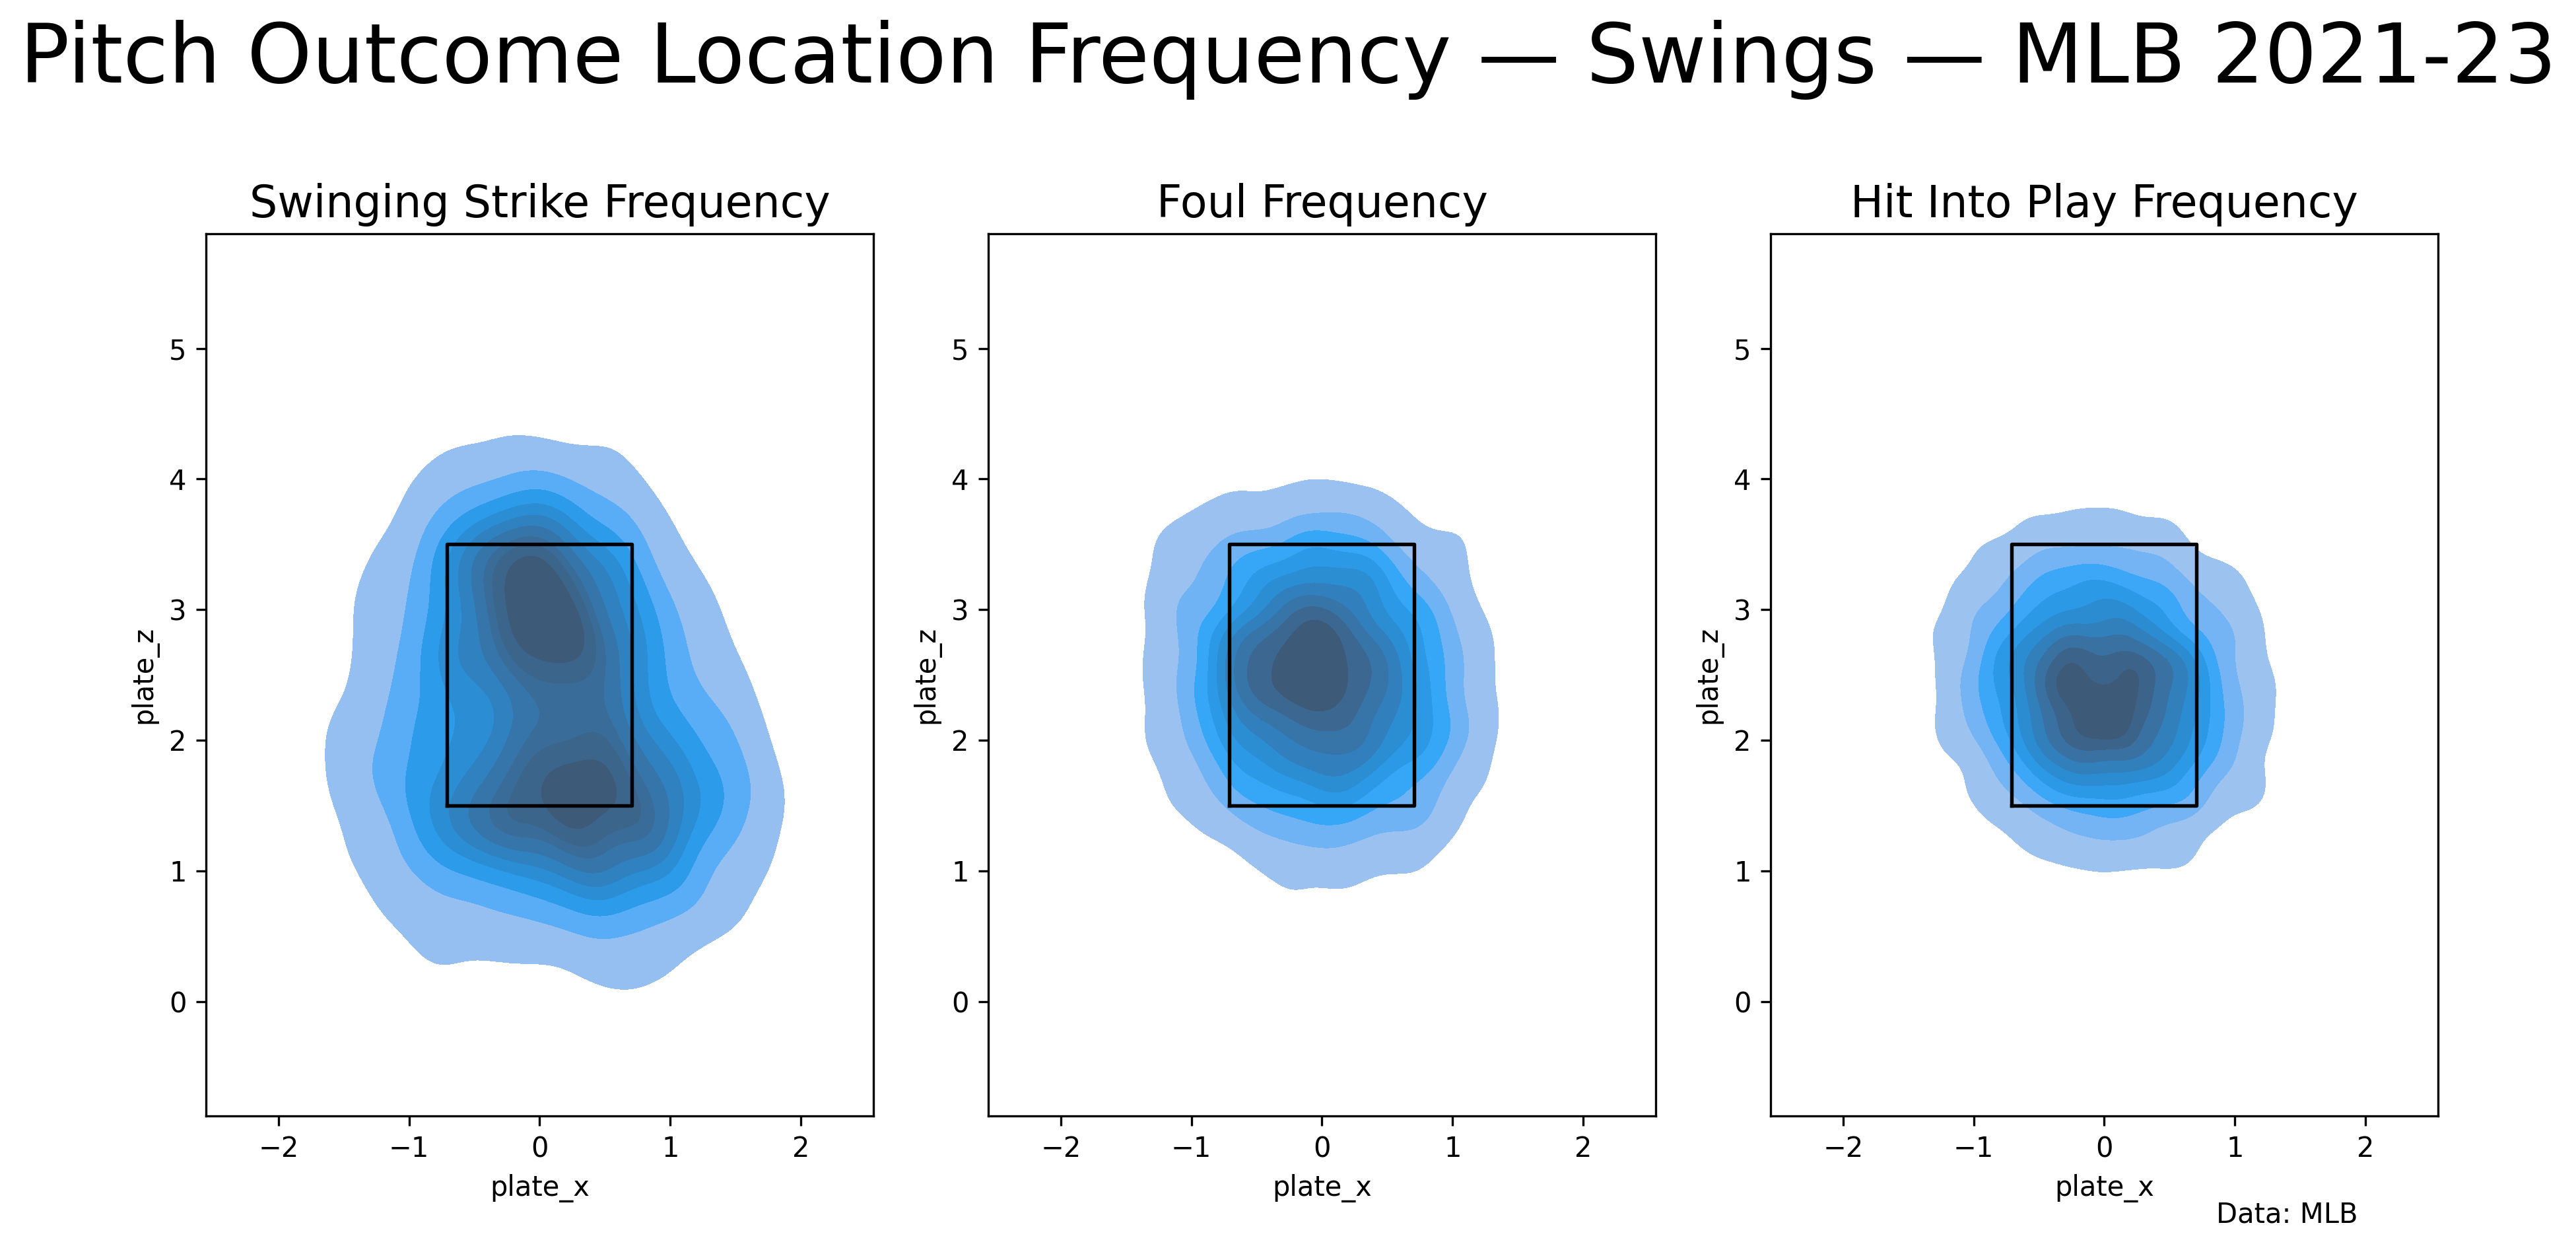

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (12, 6), dpi = 300)

sns.kdeplot(data = processed_train_data[(processed_train_data.des_new == 'swinging_strike') & (processed_train_data.swing == 1)].sample(5000),
    x = 'plate_x',
    y = 'plate_z',
    fill = True,
    ax = ax[0]
)

sns.kdeplot(data = processed_train_data[(processed_train_data.des_new == 'foul') & (processed_train_data.swing == 1)].sample(5000),
    x = 'plate_x',
    y = 'plate_z',
    fill = True,
    ax = ax[1]
)

sns.kdeplot(data = processed_train_data[(processed_train_data.description == 'hit_into_play') & (processed_train_data.swing == 1)].sample(5000),
    x = 'plate_x',
    y = 'plate_z',
    fill = True,
    ax = ax[2]
)

ax[0].axis('equal')
ax[1].axis('equal')
ax[2].axis('equal')
ax[0].set_xlim(-2, 2)
ax[1].set_xlim(-2, 2)
ax[2].set_xlim(-2, 2)

draw_line(ax[0], catcher_p = False)
draw_line(ax[1], catcher_p = False)
draw_line(ax[2], catcher_p = False)


ax[0].set_ylim(0.5, 4.5)
ax[1].set_ylim(0.5, 4.5)
ax[2].set_ylim(0.5, 4.5)

ax[0].set_title('Swinging Strike Frequency', fontsize = 16)
ax[1].set_title('Foul Frequency', fontsize = 16)
ax[2].set_title('Hit Into Play Frequency', fontsize = 16)

fig.suptitle(x = 0.5, y = 1.02, t = f"Pitch Outcome Location Frequency — Swings — MLB 2021-23", fontsize = 30)

fig.text(0.95, 0.015, "Data: MLB",ha = 'right', va = 'center', fontsize = 10)
fig.tight_layout()

In [22]:
def plot_nitro_zone(df, batter_id, year, strike_zone_dims = (3.5, 1.5, -0.708, 0.708)):
    player_df = df[(df['batter'] == batter_id) & (df['description'] == 'hit_into_play')].dropna(subset = ['plate_x', 'plate_z'])
    nitro_df = player_df[player_df['in_nitro']]
    hull = nitro_df.iloc[0, -2]
    df_name = playerid_reverse_lookup([batter_id])
    player_name = df_name['name_first'].values[0] + ' ' + df_name['name_last'].values[0]
    player_name = player_name.title()
    
    fig, ax = plt.subplots(figsize = (6, 6))
    
    # Plot all pitches
    ax.scatter(player_df['plate_x'], player_df['plate_z'], alpha = 0.2, label = 'All Pitches', color = 'skyblue')
    
    # Plot nitro zone pitches
    ax.scatter(nitro_df['plate_x'], nitro_df['plate_z'], alpha = 0.9, color = 'red', label = 'Nitro Zone Pitches')
    
    # Convex Hull around nitro pitches
    boundary_labeled = False  # Flag to track if we've already added the label
    for simplex in hull.simplices:
        if not boundary_labeled:
            ax.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'r--', lw = 2, label = 'Nitro Zone Boundary')
            boundary_labeled = True
        else:
            ax.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'r--', lw = 2)
    
    # Strike zone
    top, bottom, left, right = strike_zone_dims
    strike_x = [left, right, right, left, left]
    strike_z = [bottom, bottom, top, top, bottom]
    ax.plot(strike_x, strike_z, 'k-', lw = 2, label = 'Strike Zone')
    
    # Labels and aesthetics
    ax.set_title(f"{player_name}'s Nitro Zone in {year}")
    ax.set_xlabel("Plate X (Horizontal Location)")
    ax.set_ylabel("Plate Z (Vertical Location)")
    ax.set_xlim(-2, 2)
    ax.set_ylim(0.5, 5)
    ax.legend(loc = 'upper right')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


Gathering player lookup table. This may take a moment.


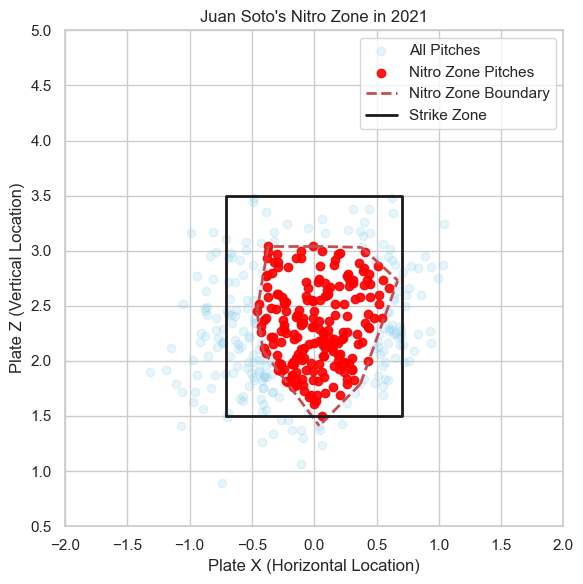

In [23]:
plot_nitro_zone(processed_data_2021, 665742, 2021)

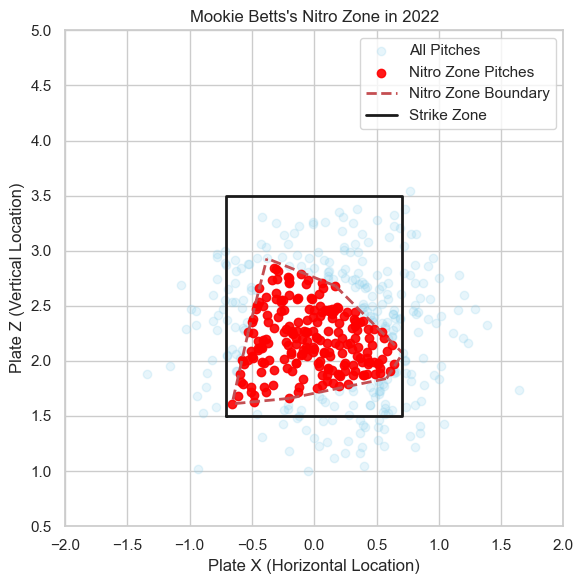

In [24]:
plot_nitro_zone(processed_data_2022, 605141, 2022)

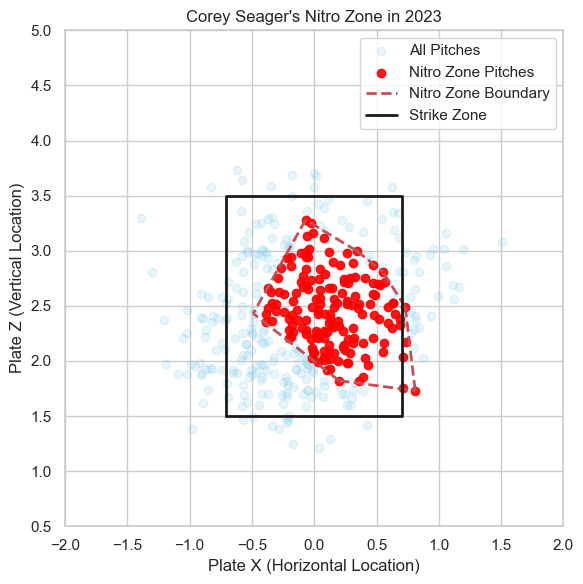

In [25]:
plot_nitro_zone(processed_data_2023, 608369, 2023)

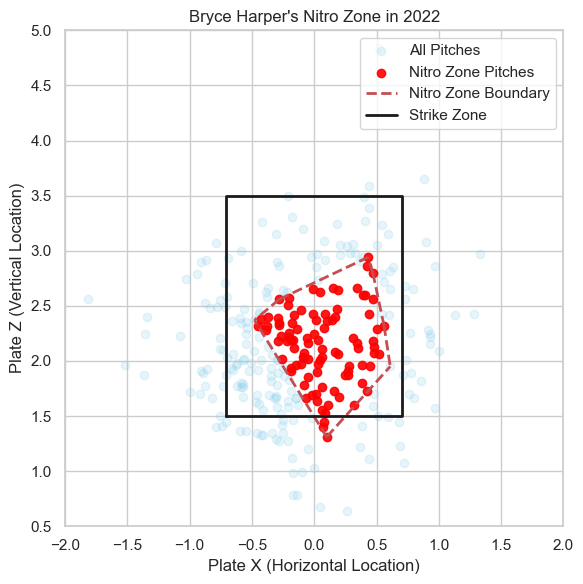

In [26]:
plot_nitro_zone(processed_data_2022, 547180, 2022)

### Modeling

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, classification_report, roc_auc_score, roc_curve
import xgboost as xgb
import lightgbm as lgb

In [17]:
def evaluate(model, dtrain, dtest):
    train_pred = model.predict(dtrain)
    train_error = root_mean_squared_error(dtrain.get_label(), train_pred)
    test_pred = model.predict(dtest)
    test_error = root_mean_squared_error(dtest.get_label(), test_pred)

    print(f'Training RMSE: {train_error}\nTesting RMSE: {test_error}')

In [18]:
def sklearn_evaluate(model, x_train, y_train, x_test, y_test):
    train_pred = model.predict(x_train)
    train_error = root_mean_squared_error(y_train, train_pred)
    test_pred = model.predict(x_test)
    test_error = root_mean_squared_error(y_test, test_pred)

    print(f'Training RMSE: {train_error}\nTesting RMSE: {test_error}')

##### Prepare Data For Models

In [19]:
features = ['plate_x', 'plate_z', 'in_nitro', 'count']
target = 'delta_run_exp_mean'

In [20]:
data_no_swing = processed_train_data.loc[processed_train_data['swing'] != 1, features + [target]]
data_swing = processed_train_data.loc[processed_train_data['swing'] == 1, features + [target]]
data_no_swing = data_no_swing.dropna().reset_index(drop = True)
data_swing = data_swing.dropna().reset_index(drop = True)

x_no_swing = data_no_swing.loc[:, features]
y_no_swing = data_no_swing.loc[:, target]
x_swing = data_swing.loc[:, features]
y_swing = data_swing.loc[:, target]

In [21]:
x_train_no_swing, x_test_no_swing, y_train_no_swing, y_test_no_swing = train_test_split(x_no_swing, y_no_swing, test_size = 0.2, random_state = seed)
x_train_swing, x_test_swing, y_train_swing, y_test_swing = train_test_split(x_swing, y_swing, test_size = 0.2, random_state = seed)

In [22]:
print(x_train_no_swing.shape)
print(x_test_no_swing.shape)
print(x_train_swing.shape)
print(x_test_swing.shape)

(849749, 4)
(212438, 4)
(772168, 4)
(193043, 4)


##### XGBoost

In [23]:
d_train_no_swing = xgb.DMatrix(x_train_no_swing, label = y_train_no_swing, enable_categorical = True)
d_test_no_swing = xgb.DMatrix(x_test_no_swing, label = y_test_no_swing, enable_categorical = True)
d_train_swing = xgb.DMatrix(x_train_swing, label = y_train_swing, enable_categorical = True)
d_test_swing = xgb.DMatrix(x_test_swing, label = y_test_swing, enable_categorical = True)

In [24]:
params = {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.03, 'eval_metric': 'rmse', 'random_state': seed, 'tree_method': 'hist'}
num_rounds = 200

In [25]:
xgb_model_no_swing = xgb.train(params, d_train_no_swing, num_rounds)

In [26]:
evaluate(xgb_model_no_swing, d_train_no_swing, d_test_no_swing) 

Training RMSE: 0.0432017557322979
Testing RMSE: 0.044595882296562195


In [27]:
params = {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 0.01, 'eval_metric': 'rmse', 'random_state': seed, 'tree_method': 'hist'}
num_rounds = 200

In [28]:
xgb_model_swing = xgb.train(params, d_train_swing, num_rounds)

In [58]:
evaluate(xgb_model_swing, d_train_swing, d_test_swing)

Training RMSE: 0.29770028591156006
Testing RMSE: 0.29807937145233154


##### LightGBM

In [29]:
d_train_no_swing = lgb.Dataset(x_train_no_swing, label = y_train_no_swing)
d_test_no_swing = lgb.Dataset(x_test_no_swing, label = y_test_no_swing)
d_train_swing = lgb.Dataset(x_train_swing, label = y_train_swing)
d_test_swing = lgb.Dataset(x_test_swing, label = y_test_swing)

In [39]:
params = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02, 'random_state': seed}
num_rounds = 800

In [40]:
lgb_model_no_swing = lgb.train(params, d_train_no_swing, num_rounds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 849749, number of used features: 4
[LightGBM] [Info] Start training from score 0.022310


In [41]:
sklearn_evaluate(lgb_model_no_swing, x_train_no_swing, y_train_no_swing, x_test_no_swing, y_test_no_swing)

Training RMSE: 0.04372641619530345
Testing RMSE: 0.0445539787490001


In [33]:
params = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02, 'random_state': seed}
num_rounds = 800

In [34]:
lgb_model_swing = lgb.train(params, d_train_swing, num_rounds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 772168, number of used features: 4
[LightGBM] [Info] Start training from score -0.022336


In [35]:
sklearn_evaluate(lgb_model_swing, x_train_swing, y_train_swing, x_test_swing, y_test_swing)

Training RMSE: 0.29805595194455864
Testing RMSE: 0.29627085430359795


##### The performance of LightGBM is slightly better. Therefore, I choosed LightGBM as my model and trained the model using all the data from 2021 to 2023.

In [21]:
d_no_swing = lgb.Dataset(x_no_swing, label = y_no_swing)
d_swing = lgb.Dataset(x_swing, label = y_swing)

In [22]:
params_no_swing = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02, 'random_state': seed}
num_rounds = 800

In [23]:
lgb_model_no_swing = lgb.train(params_no_swing, d_no_swing, num_rounds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1062187, number of used features: 4
[LightGBM] [Info] Start training from score 0.022310


In [24]:
preds = lgb_model_no_swing.predict(x_no_swing)
print(root_mean_squared_error(y_no_swing, preds))

0.04383112199455115


In [25]:
params_swing = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02, 'random_state': seed}
num_rounds = 800

In [26]:
lgb_model_swing = lgb.train(params_swing, d_swing, num_rounds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 965211, number of used features: 4
[LightGBM] [Info] Start training from score -0.022465


In [27]:
preds = lgb_model_swing.predict(x_swing)
print(root_mean_squared_error(y_swing, preds))

0.2976845393718202


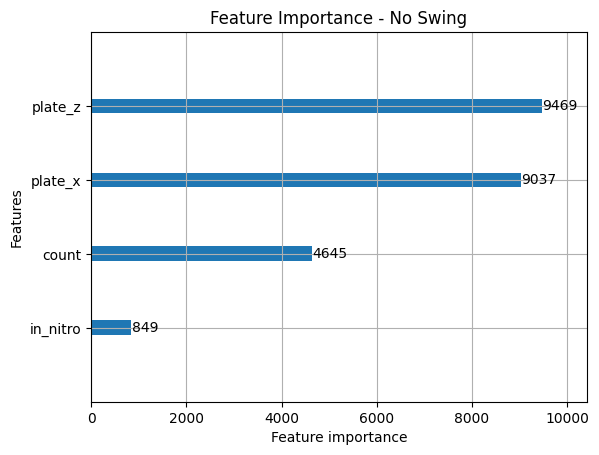

In [28]:
lgb.plot_importance(lgb_model_no_swing)
plt.title('Feature Importance - No Swing')
plt.show()

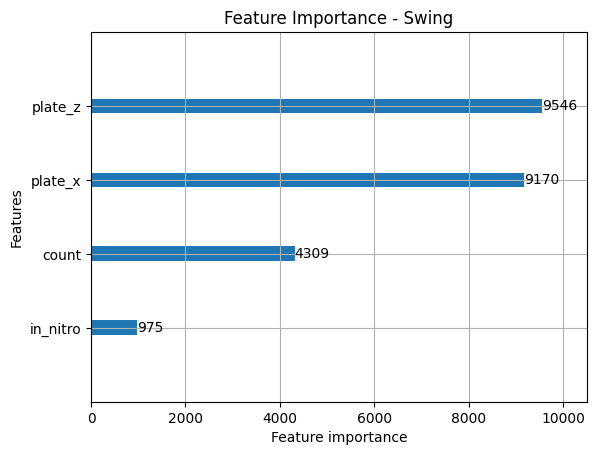

In [29]:
lgb.plot_importance(lgb_model_swing)
plt.title('Feature Importance - Swing')
plt.show()

##### Train a called strike predicitive model

In [30]:
label_mapping = {'ball': 0, 'called_strike': 1, 'hit_by_pitch': 0}

called_strike_data = processed_train_data.loc[processed_train_data['swing'] == 0, ['plate_x', 'plate_z', 'des_new']]
called_strike_data['is_called_strike'] = called_strike_data['des_new'].map(label_mapping)
called_strike_data = called_strike_data.loc[:, ['plate_x', 'plate_z', 'is_called_strike']]

In [31]:
x_train_called_strike, x_test_called_strike, y_train_called_strike, y_test_called_strike = train_test_split(called_strike_data[['plate_x', 'plate_z']], called_strike_data['is_called_strike'], test_size = 0.2, random_state = seed)

In [32]:
d_train_called_strike = xgb.DMatrix(x_train_called_strike, label = y_train_called_strike)
d_test_called_strike = xgb.DMatrix(x_test_called_strike, label = y_test_called_strike)

In [33]:
params = {'objective': 'binary:logistic', 'max_depth': 8, 'learning_rate': 0.01, 'eval_metric': 'rmse', 'random_state': seed}
num_rounds = 200

In [34]:
xgb_model_called_strike = xgb.train(params, d_train_called_strike, num_rounds)

In [35]:
train_pred_prob = xgb_model_called_strike.predict(d_train_called_strike)
train_pred = (train_pred_prob > 0.5).astype(int)
auc_score = roc_auc_score(d_train_called_strike.get_label(), train_pred_prob)
print(f'AUC Score: {auc_score}')
print(classification_report(d_train_called_strike.get_label(), train_pred))

AUC Score: 0.9819182072416811
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    585333
         1.0       0.90      0.88      0.89    264432

    accuracy                           0.93    849765
   macro avg       0.92      0.92      0.92    849765
weighted avg       0.93      0.93      0.93    849765



In [36]:
test_pred_prob = xgb_model_called_strike.predict(d_test_called_strike)
test_pred = (test_pred_prob > 0.5).astype(int)
auc_score = roc_auc_score(d_test_called_strike.get_label(), test_pred_prob)
print(f'AUC Score: {auc_score}')
print(classification_report(d_test_called_strike.get_label(), test_pred))

AUC Score: 0.9815860699387441
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95    146283
         1.0       0.90      0.88      0.89     66159

    accuracy                           0.93    212442
   macro avg       0.92      0.92      0.92    212442
weighted avg       0.93      0.93      0.93    212442



##### The called strike predicitive model performs well.

### Analysis

In [37]:
from scipy.stats import zscore
from sklearn.metrics import r2_score
import math

In [38]:
def add_batter_name(df):
    batter_data = playerid_reverse_lookup(df['batter'].values)
    batter_data['batter_name'] = batter_data['name_last'] + ', ' + batter_data['name_first']
    batter_data['batter_name'] = batter_data['batter_name'].str.title()
    batter_data = batter_data.loc[:, ['key_mlbam', 'batter_name']]
    df = df.merge(batter_data, left_on = 'batter', right_on = 'key_mlbam')

    return df

In [39]:
def calculate_player_take_decision(df):
    pitches = df.release_speed.count()
    hittable_take = np.sum([(df.swing == 0) & (df.y_pred >= 0)]) / np.sum(df.swing == 0)
    correct_take = np.sum([(df.swing == 0) & (df.y_pred <= 0)]) / np.sum(df.swing == 0)
    hittable_take *= 100
    correct_take *= 100

    return pd.Series({'pitches': pitches, 'hittable_take_percent': hittable_take, 'correct_take_percent': correct_take})

In [56]:
def calculate_player_decision_value(df, min_pitches = None):
    df_grouped = df.groupby(['batter', 'batter_name'])[['release_speed', 'swing', 'y_pred']].apply(calculate_player_take_decision).reset_index()
    df_grouped = df_grouped.loc[df_grouped['pitches'] >= min_pitches]
    df_grouped.loc[:, 'decision_value'] = df_grouped['correct_take_percent'].values - df_grouped['hittable_take_percent'].values
    df_grouped.loc[:, 'decision_value'] = zscore(df_grouped.loc[:, 'decision_value'].values)
    df_grouped.loc[:, 'decision_value'] = 100 + df_grouped['decision_value'] * 10

    return df_grouped

In [76]:
processed_train_data = add_batter_name(processed_train_data)
processed_test_data = add_batter_name(processed_test_data)

In [77]:
processed_train_data.loc[:, 'y_pred_no_swing'] = lgb_model_no_swing.predict(processed_train_data.loc[:, features])
processed_train_data.loc[:, 'y_pred_swing'] = lgb_model_swing.predict(processed_train_data.loc[:, features])
processed_train_data.loc[:, 'called_strike_prob'] = xgb_model_called_strike.predict(xgb.DMatrix(processed_train_data.loc[:, ['plate_x', 'plate_z']]))

In [78]:
processed_test_data.loc[:, 'y_pred_no_swing'] = lgb_model_no_swing.predict(processed_test_data.loc[:, features])
processed_test_data.loc[:, 'y_pred_swing'] = lgb_model_swing.predict(processed_test_data.loc[:, features])
processed_test_data.loc[:, 'called_strike_prob'] = xgb_model_called_strike.predict(xgb.DMatrix(processed_test_data.loc[:, ['plate_x', 'plate_z']]))

In [79]:
processed_train_data.loc[:, 'y_pred'] = (processed_train_data.loc[:, 'y_pred_swing'].values * processed_train_data.loc[:, 'called_strike_prob'].values) - \
                                        (processed_train_data.loc[:, 'y_pred_no_swing'].values * (1 - processed_train_data.loc[:, 'called_strike_prob'].values))

In [81]:
processed_test_data.loc[:, 'y_pred'] = (processed_test_data.loc[:, 'y_pred_swing'].values * processed_test_data.loc[:, 'called_strike_prob'].values) - \
                                        (processed_test_data.loc[:, 'y_pred_no_swing'].values * (1 - processed_test_data.loc[:, 'called_strike_prob'].values))

In [83]:
min_size = 500

In [84]:
processed_data_2023 = processed_train_data.loc[processed_train_data['game_date'] > '2023-01-01', :]
processed_data_2022 = processed_train_data.loc[(processed_train_data['game_date'] > '2022-01-01') & (processed_train_data['game_date'] < '2022-12-31'), :]

In [85]:
processed_data_2023_grouped = calculate_player_decision_value(processed_data_2023, min_pitches = min_size)
processed_data_2022_grouped = calculate_player_decision_value(processed_data_2022, min_pitches = min_size)

In [86]:
processed_data_2022_2023_grouped = pd.merge(processed_data_2022_grouped, processed_data_2023_grouped, how = 'inner', on = 'batter', suffixes =  ('_2022', '_2023'))

In [87]:
r2_result = np.power(np.corrcoef(processed_data_2022_2023_grouped['decision_value_2022'].values, processed_data_2022_2023_grouped['decision_value_2023'].values)[0][1], 2)

Text(0.05, 0.9, '$R^2$ = 0.16')

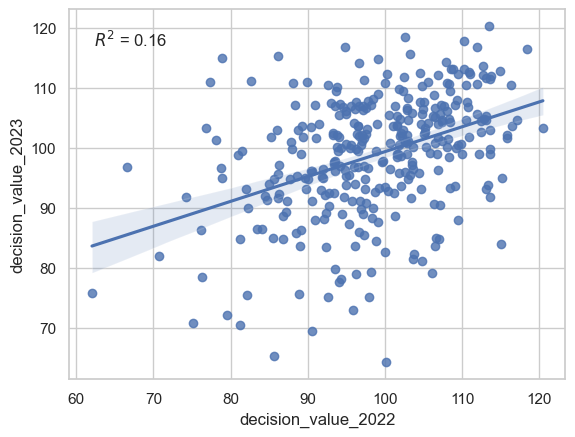

In [88]:
ax = sns.regplot(x = 'decision_value_2022', y = 'decision_value_2023', data = processed_data_2022_2023_grouped)
ax.text(0.05, 0.9, f'$R^2$ = {r2_result:.2f}', transform = ax.transAxes)

##### The decision value year to year in version 3 is less sticky than in version 1. It is not a good sign.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


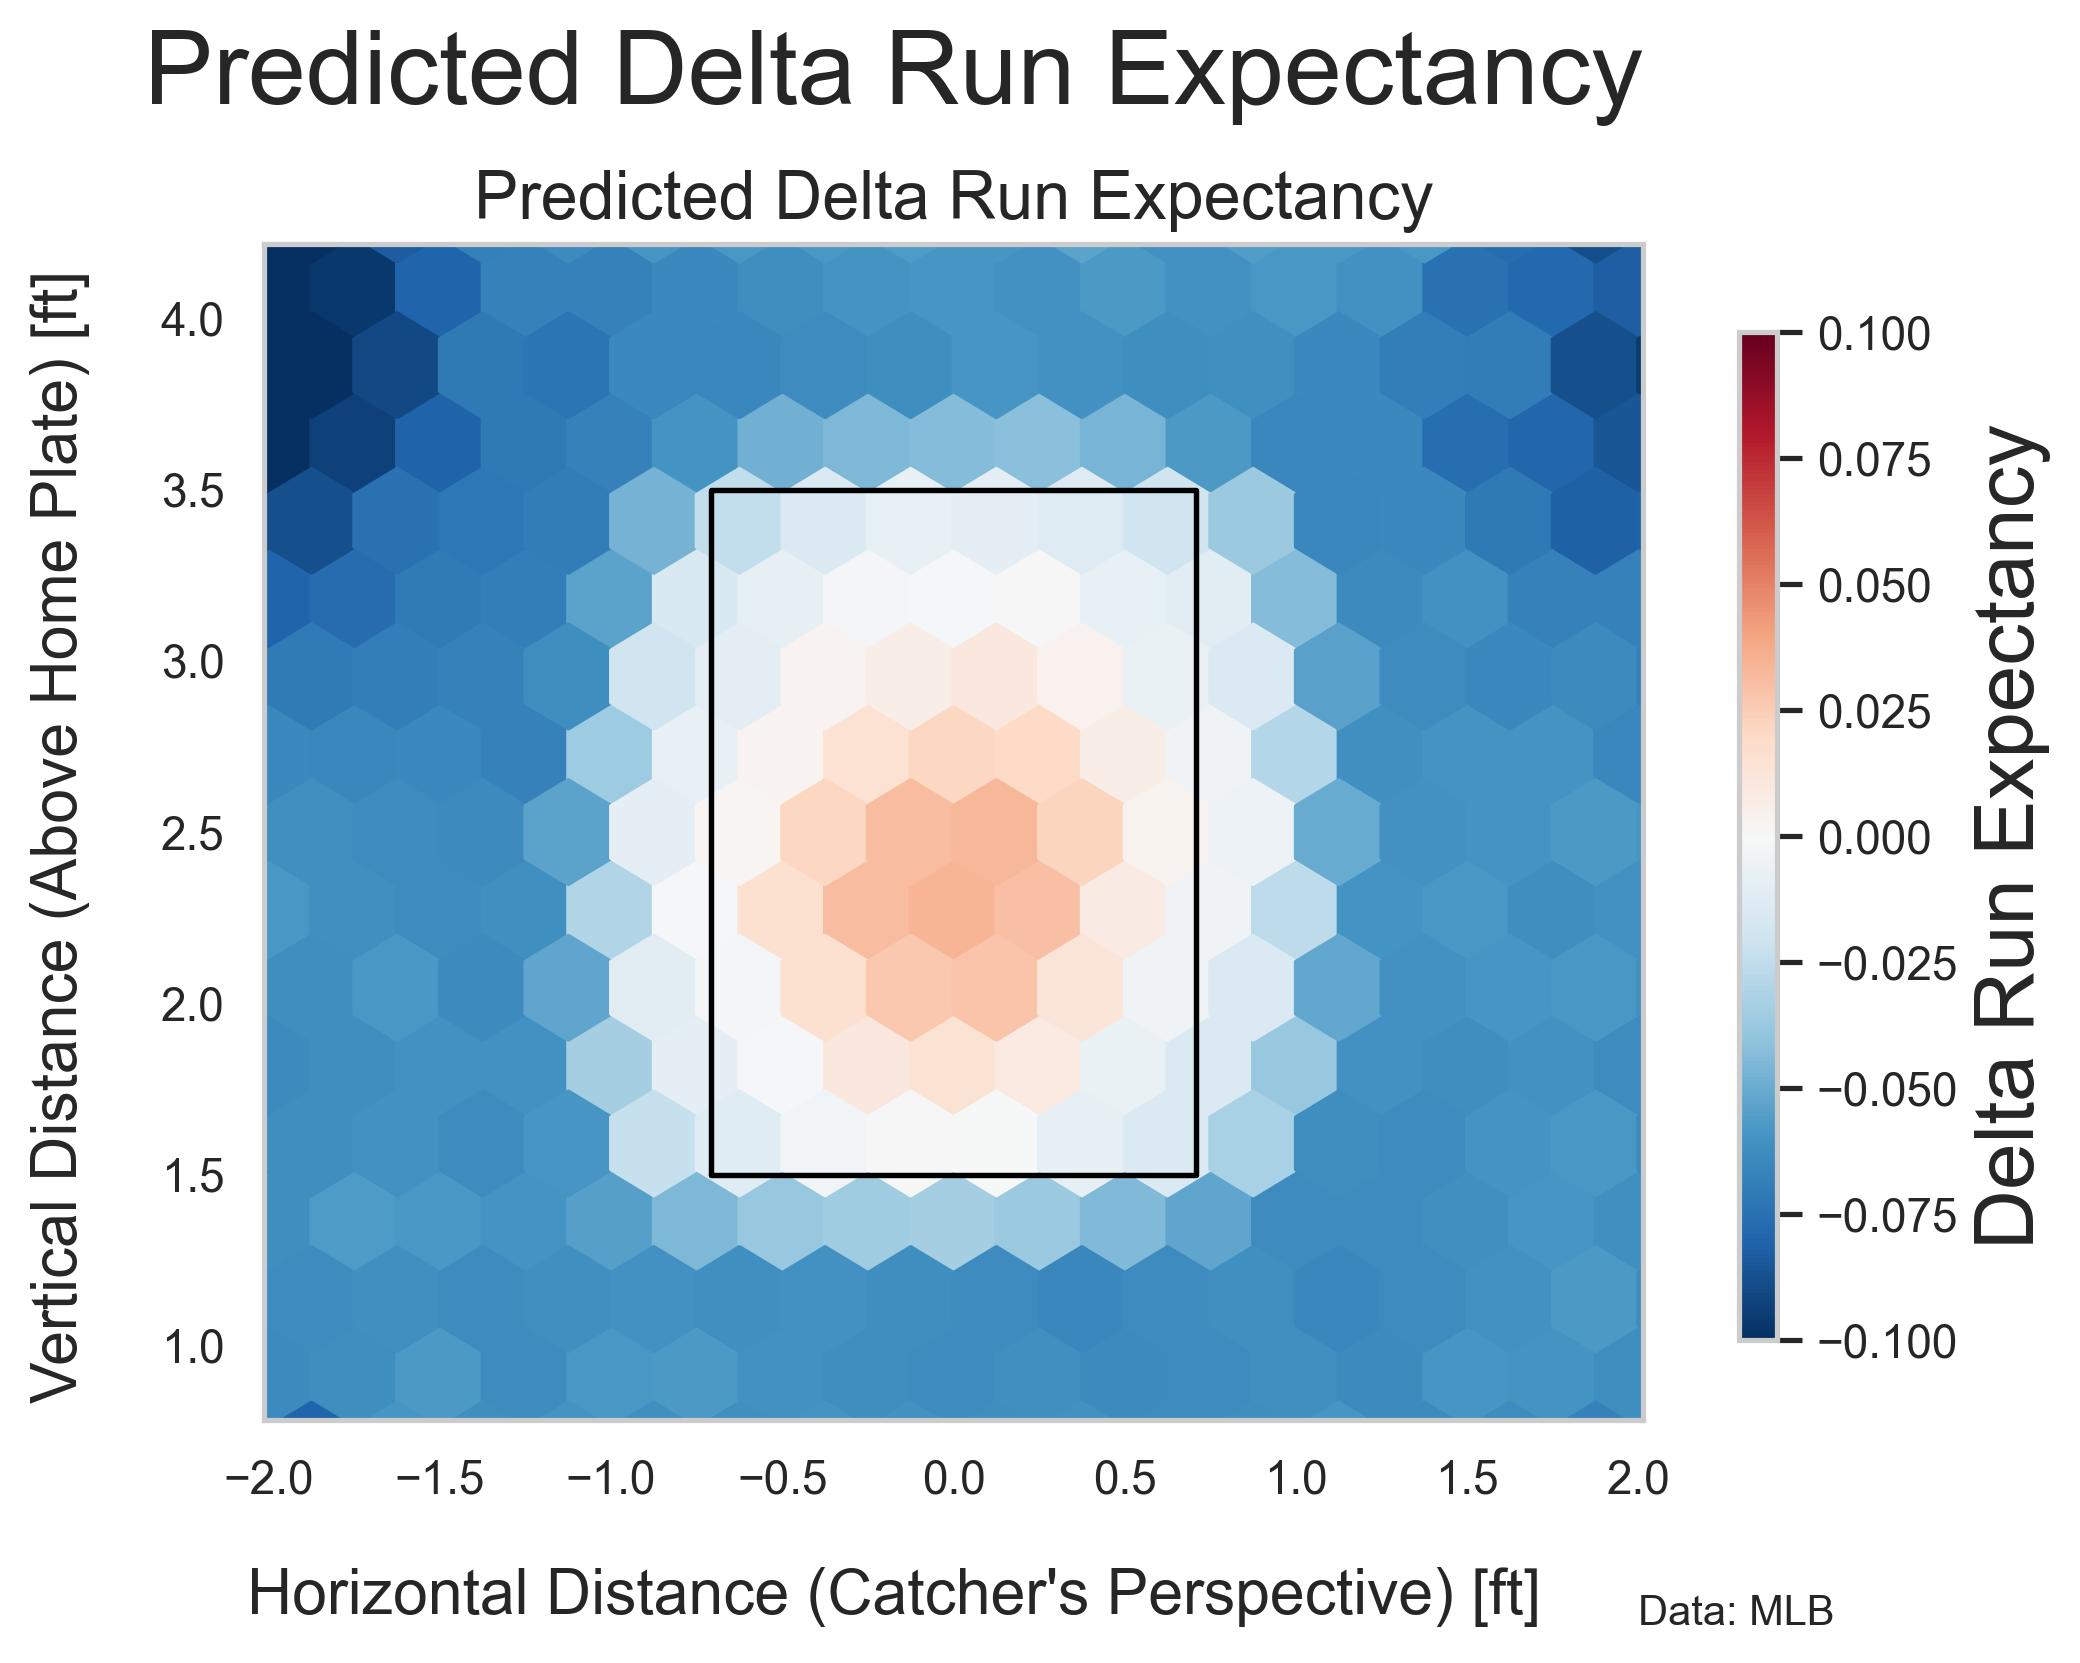

In [89]:
x_min = -2.5
x_max = 2.5
y_min = 0
y_max = 5
extent = [x_min, x_max, y_min, y_max]

# define your scale, with white at zero
vmin = -0.1
vmax = 0.1

#for p_th in range(0,2):
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(dpi = 300)
norm = colors.TwoSlopeNorm(vmin = vmin, vcenter = np.array([vmin,vmax]).mean(), vmax = vmax)
#norm = plt.Normalize(vmin,vmax)
sm = plt.cm.ScalarMappable(cmap = 'RdBu_r', norm = norm)


ax.hexbin(x = processed_test_data['plate_x'],
            y = processed_test_data['plate_z'],
            C = processed_test_data['y_pred'],
            cmap = 'RdBu_r', norm = norm, extent = extent, gridsize = 20)

ax.axis('equal')
ax.set_xlim(-1.5, 1.5)

draw_line(ax, catcher_p = False)

ax.set_ylim(1, 4)

ax.set_title('Predicted Delta Run Expectancy', fontsize = 16)
fig.tight_layout()



cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar_big = fig.colorbar(sm, cax = cbar_ax, aspect = 30, shrink = 0.7)
cbar_big.set_label('Delta Run Expectancy', fontsize = 20)

fig.subplots_adjust(right = 0.8)

fig.suptitle(x = 0.41, y = 1.06, t = f"Predicted Delta Run Expectancy", fontsize = 25)
fig.text(0.41, -0.04, "Horizontal Distance (Catcher's Perspective) [ft]", ha = 'center', fontsize = 15)
fig.text(-0.04, 0.5, "Vertical Distance (Above Home Plate) [ft]", va = 'center', rotation = 'vertical', fontsize = 15)

fig.text(0.9, -0.04, "Data: MLB",ha = 'right', va = 'center', fontsize = 10)
fig.set_facecolor('white')

In [90]:
data_2024_grouped = calculate_player_decision_value(processed_test_data, min_pitches = 500)

In [91]:
data_2024_grouped.sort_values(by = 'decision_value', ascending = False).head(10)

,batter,batter_name,pitches,hittable_take_percent,correct_take_percent,decision_value
391,681393,"Norby, Connor",759.0,4.037267,95.962733,122.013505
146,642136,"Thaiss, Matt",754.0,4.567308,95.432692,120.431127
424,687231,"Hernaiz, Darell",510.0,5.128205,94.871795,118.756629
193,657557,"Dejong, Paul",1851.0,5.405405,94.594595,117.929077
384,680779,"Davis, Henry",521.0,5.434783,94.565217,117.841375
159,645277,"Albies, Ozzie",1649.0,5.726257,94.273743,116.971210
429,687529,"Mccray, Grant",519.0,5.737705,94.262295,116.937034
454,702358,"Lipscomb, Trey",780.0,5.989583,94.010417,116.185078
22,542194,"Bethancourt, Christian",516.0,6.030151,93.969849,116.063968
44,571970,"Muncy, Max",1154.0,6.113537,93.886463,115.815027


In [92]:
data_2024_grouped.sort_values(by = 'decision_value', ascending = False).tail(10)

,batter,batter_name,pitches,hittable_take_percent,correct_take_percent,decision_value
233,664761,"Bohm, Alec",2122.0,19.756554,80.243446,75.085288
427,687401,"Ortiz, Joey",2124.0,20.263975,79.736025,73.570439
27,543685,"Rendon, Anthony",977.0,20.341880,79.658120,73.337861
156,643396,"Kiner-Falefa, Isiah",1701.0,20.633188,79.366812,72.468195
200,660688,"Ruiz, Keibert",1659.0,21.085859,78.914141,71.116795
209,663538,"Hoerner, Nico",2314.0,21.589958,78.410042,69.611861
195,657757,"Sheets, Gavin",2087.0,21.638468,78.361532,69.467039
39,571448,"Arenado, Nolan",2452.0,22.162577,77.837423,67.902371
402,682829,"De La Cruz, Elly",2751.0,22.593068,77.406932,66.617186
167,650333,"Arráez, Luis",2416.0,25.041186,74.958814,59.308596
